# Recommender Systems

## Библиотеки

In [43]:
from IPython.lib.display import IFrame
from gitdb.util import exists
from msgpack import unpack
from numba.core.typing.context import Rating
from pyarrow.includes.libarrow import kDLCPU
from spyder.utils.snippets.nodes import ElseNode
from streamlit import columns
from sympy.physics.units import years
!python3 --version

Python 3.11.7


In [44]:
pip install matplotlib pandas scipy scikit-learn torch tqdm tensorboard implicit

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 6.5 MB/s eta 0:00:0000:0100:01
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 14.9 MB/s eta 0:00:0000:0100:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm


## Данные

В качестве данных будем использовать датасет от Кино.Триколор.
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами. 

**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users_df.csv`) и описание айтемов(`items_df.csv`). 

In [47]:
data_folder = "./data_csv/"

users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"movie_id": list}).reset_index()


### Пользователи

In [48]:
users_df.head(10)

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее
5,46037,25-34,низкий,Мужской,0.0,Среднее
6,15060,18-24,средний,Мужской,0.0,Без образования
7,38702,NaN,высокий,Мужской,0.0,NaN
8,2019,25-34,низкий,Женский,NaN,NaN
9,34480,25-34,низкий,Женский,1.0,Высшее


*Какие есть признаки?*

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age_category` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя
6. `education` – уровень образования пользователя

## Айтемы

In [49]:
items_df.head(4)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,"Где-то в глубинке вместе с дочерью и внуком живет Тоня. Она ждет возвращения домой своего сына Жени, но вместо этого получает похоронку и солидную компенсацию. Оказывается, сын был наемником и погиб в Сирии. Тоня требует от властей провести расследование, но однажды Женя возвращается. Драма от продюсеров «Левиафана» и «Разжимая кулаки».",[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к разным мирам: она - хорошая девочка из приличной семьи, он - парень с трудным характером, склонный к агрессии. Их отношения начинаются с конфликта, но постепенно появляются чувства.","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 26812, 11290, 16458, 33033, 7053]",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания, друзья, любовь, притяжение, противоположностей, семейные, проблемы, смена, жизненных, приоритетов, счастье, тусовки, одиночество, преодоление, трудностей, расставания, мечта, отношения"
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица династии Тан готовится к коронации, но в это же время при дворе происходит серия таинственных смертей. Несколько чиновников буквально вспыхивают, оказавшись на солнце, и погибают от охватившего их пламени. Императрица понимает, что это дело сможет раскрыть лишь один человек – осуждённый ею детектив Ди.","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549, 7525, 25798, 31229, 33792, 31419, 12732, 28017, 17540, 23077, 27944, 5513, 19049, 17022, 4162]",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,"Вторая мировая война подходит к концу. В это время измождённый молодой рядовой крадёт мундир капитана. Он притворяется офицером, чтобы создать группу дезертиров и любыми способами построить себе иную жизнь в фашистской Германии.","[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 16631, 4514, 33184, 33165, 5861]",NaN,NaN,NaN


*Какие есть признаки?*

1. `id` – индентификатор айтема, уникален для каждого
2. `title` – Название на русском языке
3. `year` – Дата выхода
4. `date_publication` – дата публикации на платформе
5. `description` – описание (на русском)
6. `genres` - список жанров (представлен строкой)
7. `countries` – страна издания
8. `staff` – режиссер(ы), актёры
9. `title_orig` – название на английском
10. `age_rating` – возрастной рейтинг картины
11. `keywords` – ключевые слова, описывающие картину

### Страны выпуска фильмов

In [50]:
countries.head()

,id,name
0,0,Франция
1,1,Мальта
2,5,Новая Зеландия
3,8,Куба
4,10,Пуэрто-Рико


### Жанры

In [51]:
genres.head()

,id,name
0,2,Сказка
1,8,Здоровье
2,17,Наука
3,24,Комедийная мелодрама
4,38,Мистика


### Актеры, режиcсеры

In [52]:
staff.head(2)

,id,name,role
0,0,Юрий Волынцев,actor
1,1,Коннор Смит,actor


### Просмотры пользователей

#### Тренировачные данные

In [53]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,251,871


,id,datetime,user_id,movie_id,duration,is_train
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0,True
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0,True
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0,True
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0,True
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0,True


#### Тестовые данные

In [54]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 66,900


,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, 4495.0, 2744.0, 3882.0, 6450.0, 7179.0, 3516.0, 4426.0]"
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215.0, 3564.0, 1578.0, 4137.0, 3291.0, 6116.0, 308.0, 4152.0, 7211.0, 7370.0, 3174.0, 4664.0, 2207.0, 2835.0, 3242.0, 2590.0, 1760.0, 2925.0, 4715.0, 1281.0, 4473.0, 1715.0, 3512.0, 1098.0, 2952.0, 1270.0, 7108.0, 2226.0, 6626.0, 3329.0, 611.0, 4114.0, 4638.0, 1103.0, 5179.0, 4237.0, 4153.0, 2756.0, 3415.0, 5289.0, 157.0, 5293.0, 4127.0, 2145.0, 5653.0, 4588.0, 7110.0, 3464.0, 3727.0, 1811.0, 633.0]"
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, 7234.0, 5399.0, 3979.0, 2886.0, 3707.0, 4889.0, 558.0, 2355.0, 5070.0, 655.0, 4379.0, 1890.0, 7213.0, 5184.0, 6668.0, 442.0, 1671.0, 7186.0, 1163.0, 4081.0, 5133.0, 6295.0, 6201.0, 3866.0, 3148.0, 4730.0, 5500.0, 6164.0, 1161.0, 2413.0, 4263.0, 3559.0, 7154.0, 2707.0, 5336.0, 1322.0, 2591.0, 2553.0, 1849.0, 6252.0, 1188.0, 6412.0, 3150.0, 6855.0, 5458.0, 7084.0, 1166.0, 3415.0, 1909.0, 107.0, 4308.0, 1011.0, 5542.0, 6888.0, 2689.0, 4505.0, 5512.0, 6046.0, 1781.0, 3220.0, 892.0, 5007.0, 4868.0]"
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0, 7274.0, 592.0, 1141.0, 1941.0, 5571.0, 5179.0, 7410.0, 7157.0, 1401.0, 3896.0]"
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, 3705.0, 1775.0, 2510.0, 5179.0, 6112.0, 2498.0, 167.0, 4151.0, 1380.0, 6345.0, 164.0, 6594.0, 5869.0, 2759.0, 1514.0, 2465.0, 5774.0, 117.0, 3718.0, 5802.0, 2970.0, 1876.0, 5914.0, 1267.0, 1671.0, 4445.0, 6569.0, 4879.0, 5230.0, 5447.0, 7065.0, 2859.0, 7328.0, 1281.0, 5849.0, 1488.0, 592.0, 5320.0, 4486.0, 1599.0, 6509.0, 1527.0, 6660.0, 5582.0, 1976.0, 4829.0, 3242.0, 2667.0, 2870.0, 1996.0]"


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается. 
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`duration`), а так же дату последнего просмотра (`datetime`)
#### При этом на тестовых данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [55]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [56]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [57]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "movie_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,movie_id,toppopular_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, 4495.0, 2744.0, 3882.0, 6450.0, 7179.0, 3516.0, 4426.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]"
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215.0, 3564.0, 1578.0, 4137.0, 3291.0, 6116.0, 308.0, 4152.0, 7211.0, 7370.0, 3174.0, 4664.0, 2207.0, 2835.0, 3242.0, 2590.0, 1760.0, 2925.0, 4715.0, 1281.0, 4473.0, 1715.0, 3512.0, 1098.0, 2952.0, 1270.0, 7108.0, 2226.0, 6626.0, 3329.0, 611.0, 4114.0, 4638.0, 1103.0, 5179.0, 4237.0, 4153.0, 2756.0, 3415.0, 5289.0, 157.0, 5293.0, 4127.0, 2145.0, 5653.0, 4588.0, 7110.0, 3464.0, 3727.0, 1811.0, 633.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]"
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, 7234.0, 5399.0, 3979.0, 2886.0, 3707.0, 4889.0, 558.0, 2355.0, 5070.0, 655.0, 4379.0, 1890.0, 7213.0, 5184.0, 6668.0, 442.0, 1671.0, 7186.0, 1163.0, 4081.0, 5133.0, 6295.0, 6201.0, 3866.0, 3148.0, 4730.0, 5500.0, 6164.0, 1161.0, 2413.0, 4263.0, 3559.0, 7154.0, 2707.0, 5336.0, 1322.0, 2591.0, 2553.0, 1849.0, 6252.0, 1188.0, 6412.0, 3150.0, 6855.0, 5458.0, 7084.0, 1166.0, 3415.0, 1909.0, 107.0, 4308.0, 1011.0, 5542.0, 6888.0, 2689.0, 4505.0, 5512.0, 6046.0, 1781.0, 3220.0, 892.0, 5007.0, 4868.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]"
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0, 7274.0, 592.0, 1141.0, 1941.0, 5571.0, 5179.0, 7410.0, 7157.0, 1401.0, 3896.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]"
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, 3705.0, 1775.0, 2510.0, 5179.0, 6112.0, 2498.0, 167.0, 4151.0, 1380.0, 6345.0, 164.0, 6594.0, 5869.0, 2759.0, 1514.0, 2465.0, 5774.0, 117.0, 3718.0, 5802.0, 2970.0, 1876.0, 5914.0, 1267.0, 1671.0, 4445.0, 6569.0, 4879.0, 5230.0, 5447.0, 7065.0, 2859.0, 7328.0, 1281.0, 5849.0, 1488.0, 592.0, 5320.0, 4486.0, 1599.0, 6509.0, 1527.0, 6660.0, 5582.0, 1976.0, 4829.0, 3242.0, 2667.0, 2870.0, 1996.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]"


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [58]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.1213225408775555, 'recall': 0.05789212284812527}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички. 
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули. 

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички. 
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.


# Baseline #2 – Матричное разложение

In [53]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)
        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [54]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)

(207377, 5269)


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


#### Снова считаем метрики 

In [55]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.07245869600756492, 'recall': 0.03303704639228699}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

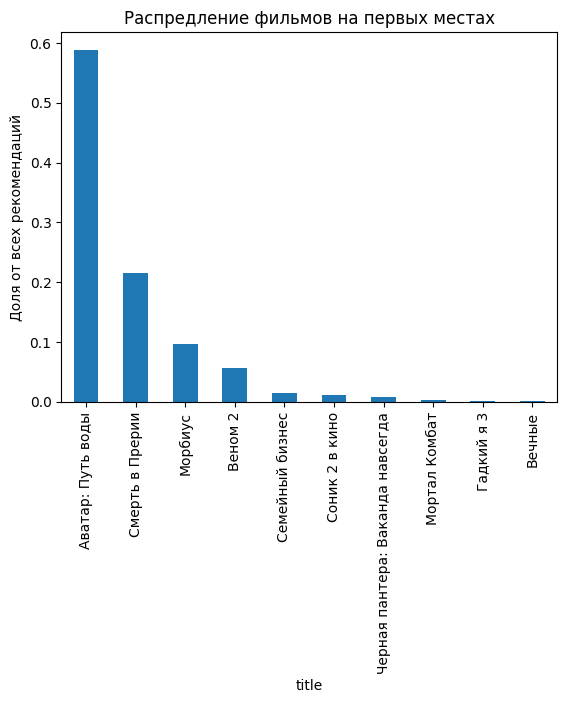

In [59]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["id"])
first_items = (
    first_items.merge(items_df[["id", "title"]], on="id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


#### Посмотрим на похожие фильмы к фильму "Аватар: Путь воды", согласно als

In [69]:
items_df[items_df["title"] == 'Аватар: Путь воды']


,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
484,484,Аватар: Путь воды,2023-01-01,2023-04-19T00:00:00,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481...",NaN,NaN,NaN


In [72]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["id"].isin(similar_ids)]["title"]


In [73]:
get_similar_films("Аватар: Путь воды")

1667                                31 июня
2848                   Великий уравнитель 2
3078                      Безымянная звезда
3088    Скандинавский форсаж: Гонки на льду
4003                        Сердце из стали
4584                            Проповедник
5141    Сестрица Алёнушка и братец Иванушка
6837                           Синяя бездна
7043                         Обратная связь
7343      Приключения на шоколадной фабрике
Name: title, dtype: object

#### Получается, что "Аватар: Путь воды" и "31 июня" довольно близки.... возможно, возможно

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).


проверим наличе связи между тем, сколько юзеры смотрят фильм и количеством кликов

Корреляция: -0.008703387702080026


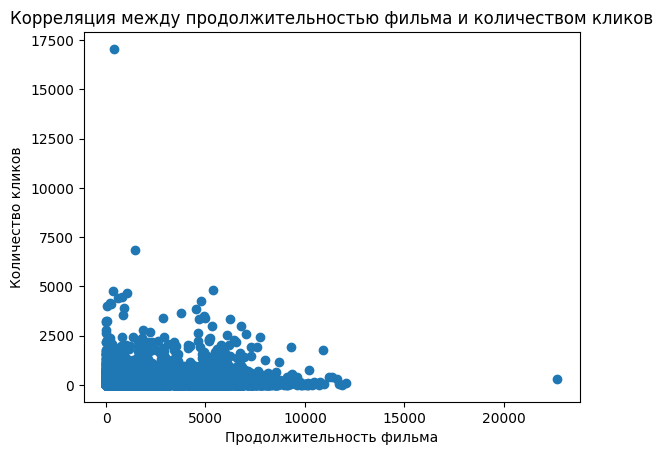

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

data_folder = "./data_csv/"
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
items_df = pd.read_csv(data_folder + "items_df.csv")

# Подсчет количества кликов на каждый фильм
clicks_per_movie = train_part['movie_id'].value_counts().reset_index()
clicks_per_movie.columns = ['movie_id', 'clicks']
merged_df = pd.merge(clicks_per_movie, items_df, left_on='movie_id', right_on='id')
merged_df = pd.merge(merged_df, train_part, left_on='movie_id', right_on='id')

correlation = merged_df['clicks'].corr(merged_df['duration'], method='pearson')
print(f"Корреляция: {correlation}")



plt.scatter(merged_df['duration'], merged_df['clicks'])
plt.xlabel('Продолжительность фильма')
plt.ylabel('Количество кликов')
plt.title('Корреляция между продолжительностью фильма и количеством кликов')
plt.show()

вывод: связи нет)))) тк проолжительность просмотра - чтото типа таргета, ровно как и количетво кликов, стоило лучше изучить данные перед тем как два таргета сравнивать


проверим гипотезы о корреляции между кликами (популярностью) и жанрами, количеством актеров

In [12]:
print("количество жанров")
correlation = merged_df['clicks'].corr(merged_df['genres'].apply(lambda x: len(x)), method='pearson')
print(f"Корреляция: {correlation}")

print("количество актеров")
correlation = merged_df['clicks'].corr(merged_df['staff'].apply(lambda x: len(x)), method='pearson')
print(f"Корреляция: {correlation}")


количество жанров
Корреляция: 0.2049636029690019
количество актеров
Корреляция: 0.09464232388401791


вывод: чем больше указано жанров, тем больше воронка юзеров? попадает в большее количество фильтров/выборок

In [109]:
from collections import Counter
from pprint import pprint



построим модель которая будет опираться на популярность актеров, снимавшихся в фильме, будем строить рейтинг как в "веселых стартах" чем популярнее актер в рейтинге, тем меньше очков начислим фильму, потом отсортируем во неубыванию и получим рейтинг
 

In [105]:
class TopStaff(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "movie_id") -> None:
        # строим топ актеров
        staff = []
        for s in df.staff:
            staff_cur = [i for i in s[1:-1].split(', ') if i]
            staff += list(map(int, staff_cur))

        staff_top = [x[0] for x in sorted(Counter(staff_u).items(), key=lambda x: x[1], reverse=True)]
        rating = { k: i for i, k in enumerate(staff_top) }
        # строим топ фильмов по актерам
        staff_score = []
        for s in df.staff:
            staff_score.append(sum(rating[int(i)] for i in s[1:-1].split(", ") if i and int(i) in rating))
        
        df = pd.concat([df, pd.DataFrame(staff_score, columns=["staff_score"])])
        df = df.sort_values(by=["staff_score"])
        
        self.recommendations = tuple(df.index)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)



merged_df = pd.merge(train_part, items_df, left_on='id', right_on='id')


topstaff = TopStaff()
topstaff.fit(merged_df)
test_part["topstaff_recs"] = topstaff.predict(test_part)
test_part.head()

evaluate_recommender(test_part, model_preds_col="topstaff_recs")

{'ndcg': 0.023047200310688, 'recall': 0.008731060901671287}

In [107]:
test_part

,user_id,movie_id,toppopular_recs,topstaff_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, 4495.0, 2744.0, 3882.0, 6450.0, 7179.0, 3516.0, 4426.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215.0, 3564.0, 1578.0, 4137.0, 3291.0, 6116.0, 308.0, 4152.0, 7211.0, 7370.0, 3174.0, 4664.0, 2207.0, 2835.0, 3242.0, 2590.0, 1760.0, 2925.0, 4715.0, 1281.0, 4473.0, 1715.0, 3512.0, 1098.0, 2952.0, 1270.0, 7108.0, 2226.0, 6626.0, 3329.0, 611.0, 4114.0, 4638.0, 1103.0, 5179.0, 4237.0, 4153.0, 2756.0, 3415.0, 5289.0, 157.0, 5293.0, 4127.0, 2145.0, 5653.0, 4588.0, 7110.0, 3464.0, 3727.0, 1811.0, 633.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, 7234.0, 5399.0, 3979.0, 2886.0, 3707.0, 4889.0, 558.0, 2355.0, 5070.0, 655.0, 4379.0, 1890.0, 7213.0, 5184.0, 6668.0, 442.0, 1671.0, 7186.0, 1163.0, 4081.0, 5133.0, 6295.0, 6201.0, 3866.0, 3148.0, 4730.0, 5500.0, 6164.0, 1161.0, 2413.0, 4263.0, 3559.0, 7154.0, 2707.0, 5336.0, 1322.0, 2591.0, 2553.0, 1849.0, 6252.0, 1188.0, 6412.0, 3150.0, 6855.0, 5458.0, 7084.0, 1166.0, 3415.0, 1909.0, 107.0, 4308.0, 1011.0, 5542.0, 6888.0, 2689.0, 4505.0, 5512.0, 6046.0, 1781.0, 3220.0, 892.0, 5007.0, 4868.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0, 7274.0, 592.0, 1141.0, 1941.0, 5571.0, 5179.0, 7410.0, 7157.0, 1401.0, 3896.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, 3705.0, 1775.0, 2510.0, 5179.0, 6112.0, 2498.0, 167.0, 4151.0, 1380.0, 6345.0, 164.0, 6594.0, 5869.0, 2759.0, 1514.0, 2465.0, 5774.0, 117.0, 3718.0, 5802.0, 2970.0, 1876.0, 5914.0, 1267.0, 1671.0, 4445.0, 6569.0, 4879.0, 5230.0, 5447.0, 7065.0, 2859.0, 7328.0, 1281.0, 5849.0, 1488.0, 592.0, 5320.0, 4486.0, 1599.0, 6509.0, 1527.0, 6660.0, 5582.0, 1976.0, 4829.0, 3242.0, 2667.0, 2870.0, 1996.0]","[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
...,...,...,...,...
66895,176506,[1515.0],"[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
66896,176519,[4167.0],"[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
66897,176525,[5947.0],"[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"
66898,176531,[5514.0],"[484.0, 6194.0, 641.0, 2679.0, 2820.0, 5876.0, 5336.0, 2074.0, 1978.0, 2480.0]","(6987, 1985, 5926, 4372, 5918, 5914, 4373, 1982, 1978, 4376)"


Вывод: гипотеза не очень зашла, очень узкая информация для того чтобы сделать вывод о популярности фильма, думаю что рекомендатор по популярным фильмам аггрегирует в себе и этот подход в том числе неявно